# Writeup for Advanced Lane Finding Project

The goals / steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Step 1: Find the chessboard corners 

Remove any distortion from the images by calculating the camera calibration matrix and distortion coefficients using a series of chessboard images.

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

nx= 9
ny= 6

objp = np.zeros((nx * ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

### Loop through all the grayscale images and generate object points and corner
### coordinate arrays
objpoints = [] 
corner_points = []



images = glob.glob('camera_cal/calibration*.jpg')
all_img_gray=[]
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    all_img_gray.append(gray)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    if ret == True:
        objpoints.append(objp)
        corner_points.append(corners)

## Step 2: Calculate the Camera Calibration

Calculate distortion coefficients to remove the distortion from an image.

In [4]:
corner_points = np.array(corner_points)
objpoints = np.array(objpoints)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, corner_points, (img.shape[1], img.shape[0]), None, None)

Now, we can test the undistortion on the chessboard images

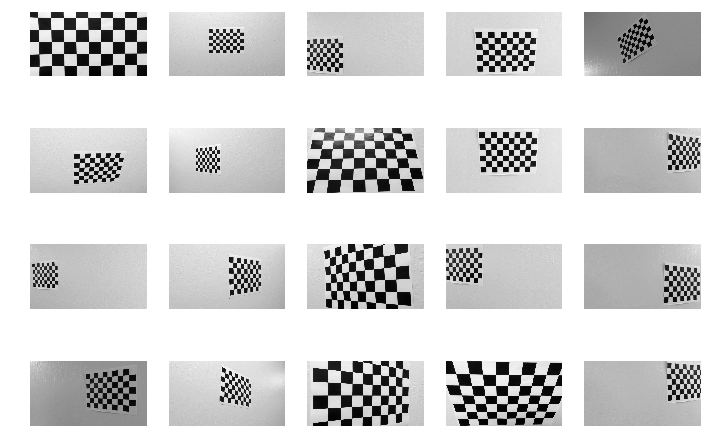

In [5]:
fig, ax = plt.subplots(4,5, figsize = (12,8))
for i, im in enumerate(all_img_gray):
    img = cv2.undistort(im, mtx, dist, None, mtx)
    
    ax[i%4, (i-i%4)%5].imshow(img, cmap='gray')
    ax[i%4, (i-i%4)%5].axis('off')



## Step 3: Apply undistortion to the Camera Images

The next step is to inport our Lane Data and apply our un-distort filter to it. For that we've got 8 example images, which we can use to run our Lane Finding Algorithm on.
First things first, we take inthe image data and undistort them

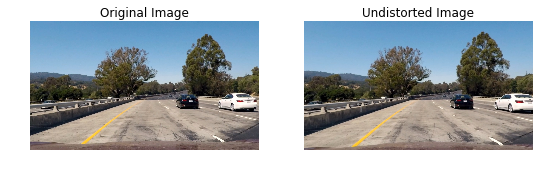

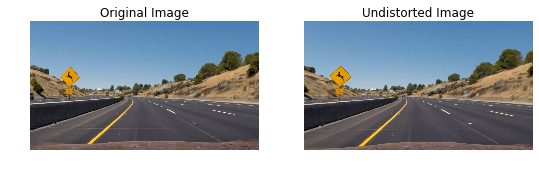

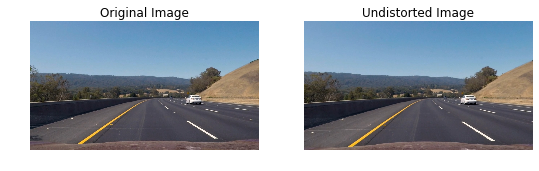

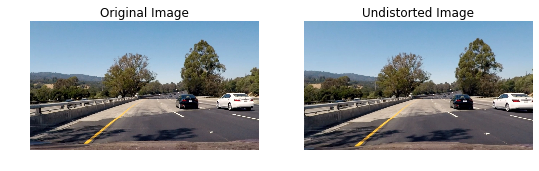

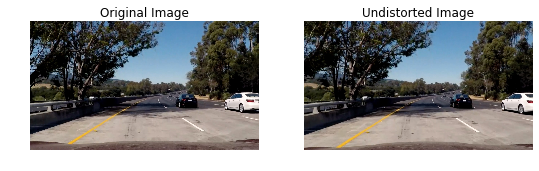

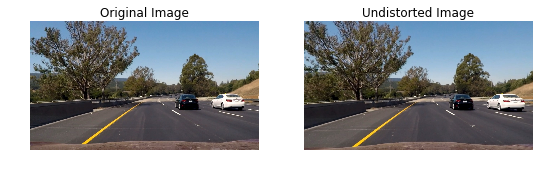

In [6]:
path_images = 'test_images/test*.jpg'
cam_files=glob.glob(path_images)

images_cam = []

for i, path in enumerate(cam_files):
    image = cv2.imread(path)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    images_cam.append(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(nx,ny))
    ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax1.axis('off')
    ax1.set_title('Original Image', fontsize=12)
    
    
    ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    ax2.axis('off')
    ax2.set_title('Undistorted Image', fontsize=12)
     

Above we can see both the distorted and undistorted image. In modern camera lenses tend to bend the light more unprecicely close to the edges, this is why images are most distorted in corner regions.

## Step 4: Perspective Transform: 

In the next step, the image has to be transformed to yield a better edge detection. The best way to do so is looking at the performance of different approaches and actually combine them in a last step to get most of all the algorithms.
In this step, the images will be transformed in a perspective transform. To do this, we define 4 points of origin, which form a rectangle in the birds-eye view. 

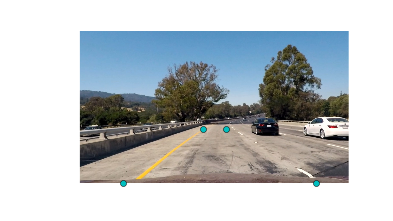

In [8]:
# visualization of source points
# src
a=[585, 460] 
b=[203, 720]
c=[1127, 720]
d=[695, 460]


#dst 
at=[320, 0]
bt=[320, 720]
ct=[960, 720]
dt=[960, 0]

 
plt.imshow(images_cam[0])
plt.figure(1)
plt.axis('off')
plt.plot([a[0], b[0], c[0], d[0]], [a[1], b[1], c[1], d[1]], 'co')
plt.show()

The warped image now shows the birds-view of the road. In order to get a better crop of the image, the image is now also cropped to the region of interest.

In [9]:
from matplotlib.lines import Line2D  
#img: undistorted image
def corners_unwarp(img,src,dst):
    
    (line1s_x, line1s_y) = zip(src[0], src[1])
    (line2s_x, line2s_y) = zip(src[2], src[3])
    (line3s_x, line3s_y) = zip(src[0], src[3])

    (line1d_x, line1d_y) = zip(dst[0], dst[1])
    (line2d_x, line2d_y) = zip(dst[2], dst[3])
    (line3d_x, line3d_y) = zip(dst[0], dst[3])
    
    img_size = (img.shape[1], img.shape[0])
    offset = 0
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image 
    warped = cv2.warpPerspective(img, M, img_size,flags=cv2.INTER_LINEAR)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    f.tight_layout()
    ax1.axis('off')
    ax1.imshow(img)
    ax1.add_line(Line2D(line1s_x, line1s_y, linewidth=1, color='cyan', ls=':'))
    ax1.add_line(Line2D(line2s_x, line2s_y, linewidth=1, color='cyan', ls=':'))
    ax1.add_line(Line2D(line3s_x, line3s_y, linewidth=1, color='cyan', ls=':'))
    ax1.set_title('Undistorted Image', fontsize=12)
    
    ax2.axis('off')
    ax2.imshow(warped)
    ax2.add_line(Line2D(line1d_x, line1d_y, linewidth=1, color='cyan', ls=':'))
    ax2.add_line(Line2D(line2d_x, line2d_y, linewidth=1, color='cyan', ls=':'))
    ax2.add_line(Line2D(line3d_x, line3d_y, linewidth=1, color='cyan', ls=':'))
    ax2.set_title('Warped Image', fontsize=12)

    return warped, M

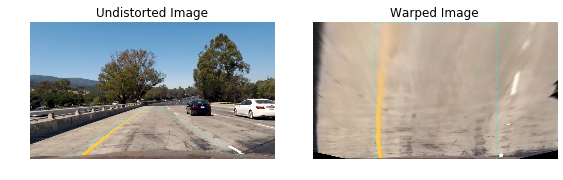

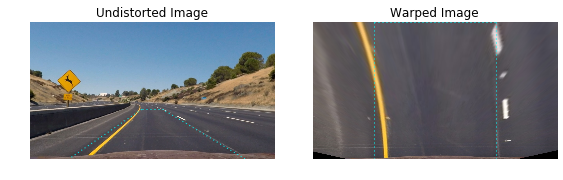

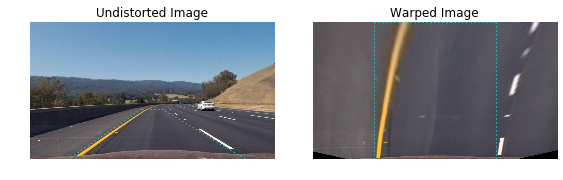

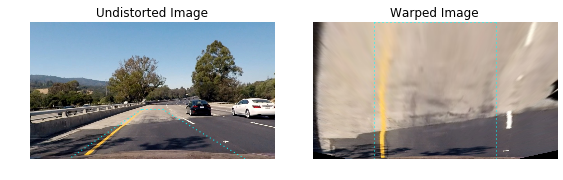

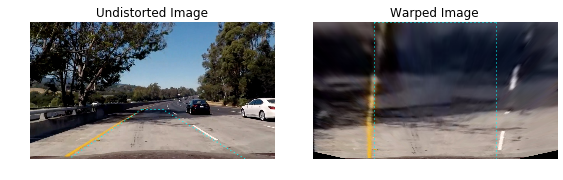

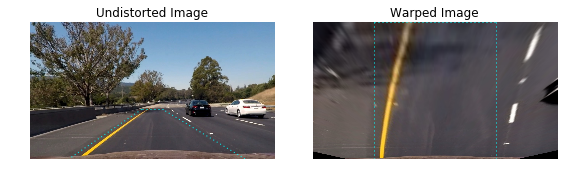

In [10]:
src = np.float32([[585, 460],[203, 720], 
                  [1127, 720],[695, 460]])
dst = np.float32([[320, 0], [320, 720], 
                  [960, 720],[960, 0]])

warped_images =[]
for i, im in enumerate(images_cam):
    warped,_=corners_unwarp(im,src,dst)
    warped_images.append(warped)
    

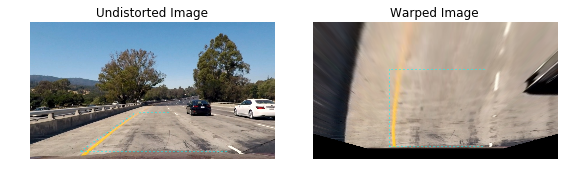

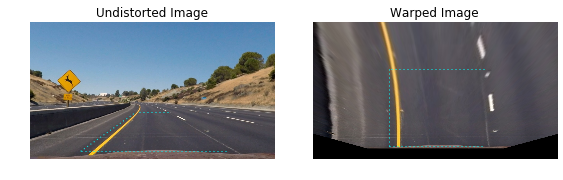

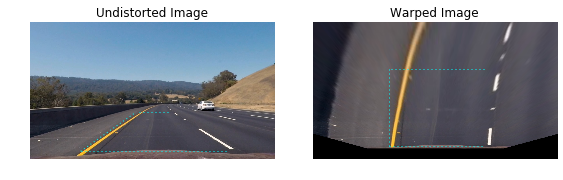

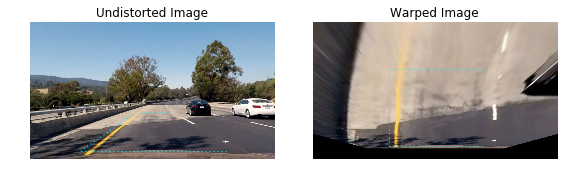

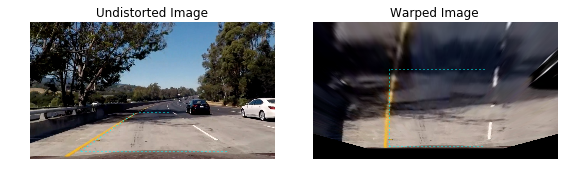

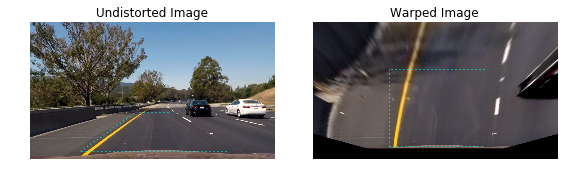

In [159]:
# playing with another scr and dst points
src = np.float32([[265, 680], [1045, 680],
                  [725, 475], [555, 475]])
dst = np.float32([[400, 650], [900, 650],
                  [900, 250], [400, 250]])

for i, im in enumerate(images_cam):
    corners_unwarp(im,src,dst)

### Step 5: Create binary Image based on Threshold

To capture car lane lines, I combined the binary threshold of the S channel from HLS, L channel from LUV, and B from Lab. As you can see below each channel is good at detecting specific line colors, for example S in HLS is good at detecting both yellow and white car lines.

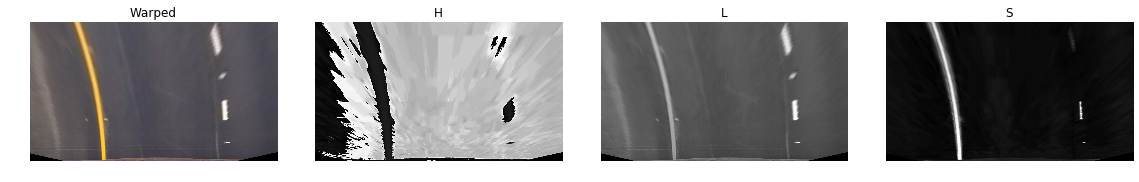

In [162]:
# first: HLS 
def option_HLS(image):

    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,4))
    f.tight_layout()
    
    ax1.axis('off')
    ax1.imshow(image)
    ax1.set_title('Warped', fontsize=12)  
    
    ax2.axis('off')
    ax2.imshow(hls[:,:,0], cmap='gray')
    ax2.set_title('H', fontsize=12)
    
    ax3.axis('off')
    ax3.imshow(hls[:,:,1], cmap='gray')
    ax3.set_title('L', fontsize=12)
    
    ax4.axis('off')
    ax4.imshow(hls[:,:,2], cmap='gray')
    ax4.set_title('S', fontsize=12)        


option_HLS(warped_images[1])

As can be seen S channel has done a really good job at detecting yellow and white lines.

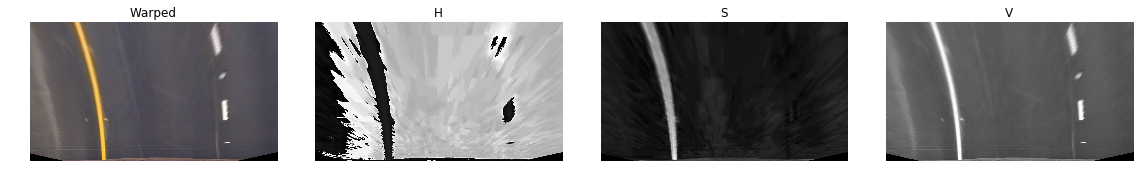

In [163]:
# second: HSV 
def option_HSV(image):

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,4))
    f.tight_layout()
    
    ax1.axis('off')
    ax1.imshow(image)
    ax1.set_title('Warped', fontsize=12)    
    
    ax2.axis('off')
    ax2.imshow(hsv[:,:,0], cmap='gray')
    ax2.set_title('H', fontsize=12)
    
    ax3.axis('off')
    ax3.imshow(hsv[:,:,1], cmap='gray')
    ax3.set_title('S', fontsize=12)
    
    ax4.axis('off')
    ax4.imshow(hsv[:,:,2], cmap='gray')
    ax4.set_title('V', fontsize=12)        

option_HSV(warped_images[1])

As can be seen V channel has done a really good job at detecting yellow and white lines.

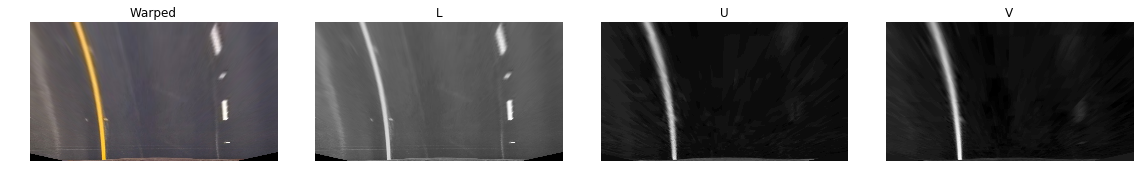

In [164]:
# third: LUV
def option_LUV(image):

    luv = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,4))
    f.tight_layout()
    
    ax1.axis('off')
    ax1.imshow(image)
    ax1.set_title('Warped', fontsize=12)    
    
    ax2.axis('off')
    ax2.imshow(luv[:,:,0], cmap='gray')
    ax2.set_title('L', fontsize=12)
    
    ax3.axis('off')
    ax3.imshow(luv[:,:,1], cmap='gray')
    ax3.set_title('U', fontsize=12)
    
    ax4.axis('off')
    ax4.imshow(luv[:,:,2], cmap='gray')
    ax4.set_title('V', fontsize=12)        

option_LUV(warped_images[1])

As can be seen L channel has done a really good job at detecting yellow and white lines.

I chose a combined binary threshold based on the three above mentioned binary thresholds. This threshold can highlighting almost all of the white and yellow lane lines.

In [3]:
# Create binary thresholded images to see the region of interest in the image (lane line pixels)

def combine_thresholds(image):

    S_channel = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
    
    L_channel = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)[:,:,0]

    B_channel = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)[:,:,2]   

    # Threshold color channel
    S_thresh_min = 150 #180
    S_thresh_max = 255 #225
    S_binary = np.zeros_like(S_channel)
    S_binary[(S_channel >= S_thresh_min) & (S_channel <= S_thresh_max)] = 1
    
    B_thresh_min = 145 #155 
    B_thresh_max = 200 #145
    B_binary = np.zeros_like(B_channel)
    B_binary[(B_channel >= B_thresh_min) & (B_channel <= B_thresh_max)] = 1
    
    L_thresh_min = 215 #200
    L_thresh_max = 255 #215
    L_binary = np.zeros_like(L_channel)
    L_binary[(L_channel >= L_thresh_min) & (L_channel <= L_thresh_max)] = 1

    
    combined_binary_all = np.zeros_like(S_binary)
    combined_binary_all[(S_binary == 1) | (L_binary == 1) | (B_binary == 1)] = 1

    combined_binary_LB = np.zeros_like(S_binary)
    combined_binary_LB[(L_binary == 1) | (B_binary == 1)] = 1
   
#     # Plotting thresholded images 
#     f, ((ax1, ax2, ax3, ax4, ax5, ax6)) = plt.subplots(1, 6, figsize=(15,9))
#     f.tight_layout()
    
#     # 
        
#     ax1.axis('off')
#     ax1.set_title('Warped Image', fontsize=12)
#     ax1.imshow(image) 
#     ax2.axis('off')
#     ax2.set_title('S threshold', fontsize=12)
#     ax2.imshow(S_binary, cmap='gray')
        
#     ax3.axis('off')
#     ax3.set_title('B threshold', fontsize=12)
#     ax3.imshow(B_binary, cmap='gray')
        
#     ax4.axis('off')
#     ax4.set_title('L threshold', fontsize=12)
#     ax4.imshow(L_binary, cmap='gray')

#     ax5.axis('off')
#     ax5.set_title('Combined all thresholds', fontsize=12)
#     ax5.imshow(combined_binary_all, cmap='gray')
        
#     ax6.axis('off')
#     ax6.set_title('Combined  L & B thresholds', fontsize=12)
#     ax6.imshow(combined_binary_LB, cmap='gray')
        
#     plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
    
    return combined_binary_LB

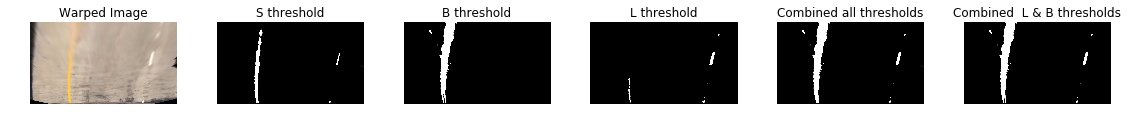

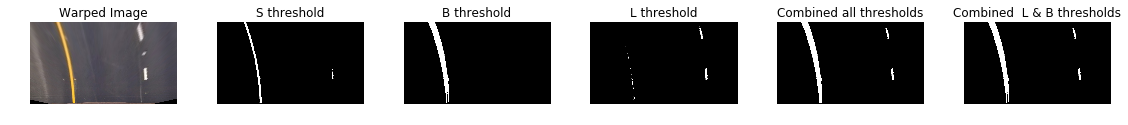

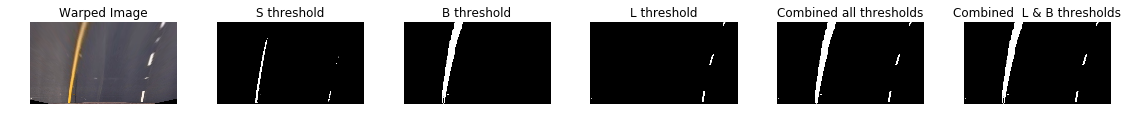

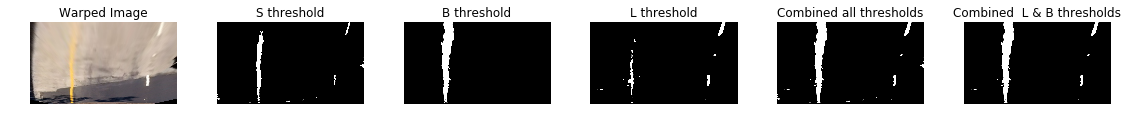

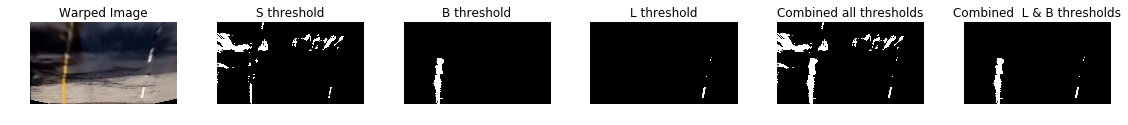

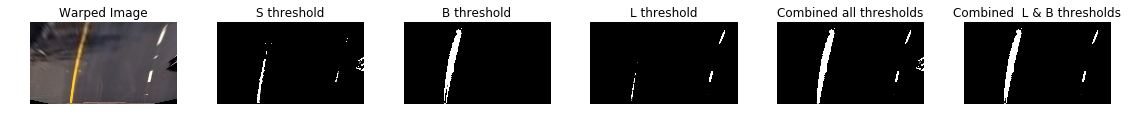

In [13]:
combined_binary_LB_images=[]
for i, im in enumerate(warped_images):
    combined_binary_LB = combine_thresholds(im)
    combined_binary_LB_images.append(combined_binary_LB)

Because S channel added some noise to the binary image (as can be seen in combined all thresholds images) and interfered with detecting lane lines accurately so, I decided to remove that in final combination after all and only consider L & B channels.

### Step 6: Finding the lane pixels using Histogram and  Fitting a polynomial to the lane lines

In this step I used histogram to find the peak points; these points can be identified as the lane pixels.

left side: 368 right side: 1002


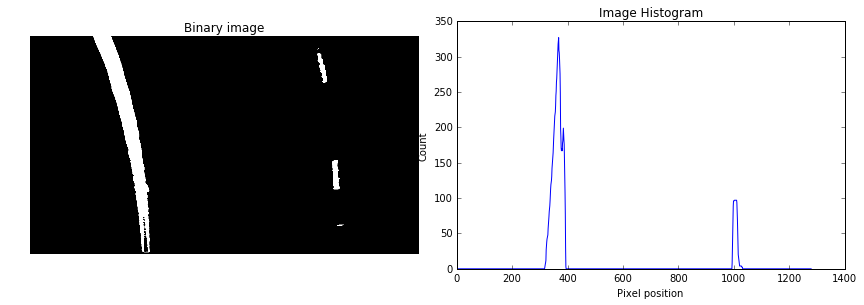

In [14]:
def Histogram_peak(image):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    f.tight_layout()

    ax1.axis('off')
    ax1.set_title('Binary image', fontsize=12)
    ax1.imshow(image, cmap='gray')  

    histogram = np.sum(image[image.shape[0]//2:, :], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_side = np.argmax(histogram[:midpoint])
    rightx_side = np.argmax(histogram[midpoint:]) + midpoint
    
    ax2.plot(histogram)
    ax2.set_title('Image Histogram', fontsize=12)
    ax2.set_xlabel('Pixel position')
    ax2.set_ylabel('Count')
    print ('left side: '+ str(leftx_side),'right side: '+ str(rightx_side))

Histogram_peak(combined_binary_LB_images[1])


In [4]:
def poly_fit(image):
    #image = combined binary warped images
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)

    output_img = np.dstack((image, image, image))*255
    
   
    # Find the peak of the left and right of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_side = np.argmax(histogram[:midpoint])
    rightx_side = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    n_side_win = 9
    # Set height of windows
    win_h = np.int(image.shape[0]/n_side_win)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_side
    rightx_current = rightx_side
    
    margin = 100 #80
    # Set minimum number of pixels found to recenter window
    minpix = 50 #45
    # Create empty lists to receive left and right lane pixel 
    left_lane_idx = []
    right_lane_idx = []

    # Step through the windows one by one
    for win in range(n_side_win):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (win+1)*win_h
        win_y_high = image.shape[0] - win*win_h
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on image
        cv2.rectangle(output_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(255,255,0), 2) 
        cv2.rectangle(output_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(255,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        nonzero_left_idx = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xleft_low) & (nonzero_x < win_xleft_high)).nonzero()[0]
        nonzero_right_idx = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xright_low) & (nonzero_x < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_idx.append(nonzero_left_idx)
        right_lane_idx.append(nonzero_right_idx)
        
        
        if len(nonzero_left_idx) > minpix:
            leftx_current = np.int(np.mean(nonzero_x[nonzero_left_idx]))
        if len(nonzero_right_idx) > minpix:        
            rightx_current = np.int(np.mean(nonzero_x[nonzero_right_idx]))

    # Concatenate the arrays of indices
    left_lane_idx = np.concatenate(left_lane_idx)
    right_lane_idx = np.concatenate(right_lane_idx)

    # Extract left and right line pixel positions
    leftx = nonzero_x[left_lane_idx]
    lefty = nonzero_y[left_lane_idx] 
    rightx = nonzero_x[right_lane_idx]
    righty = nonzero_y[right_lane_idx] 
    
    
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit =[]
    else:
        left_fit = np.polyfit(lefty, leftx, 2)

    if len(rightx) == 0:
        right_fit =[]
    else:
        right_fit = np.polyfit(righty, rightx, 2)
    

    output_img[nonzero_y[left_lane_idx], nonzero_x[left_lane_idx]] = [255, 0, 0]
    output_img[nonzero_y[right_lane_idx], nonzero_x[right_lane_idx]] = [0, 0, 255]
    
#     f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12,4))
#     f.tight_layout()
        
#     #ax1.axis('off')
#     ax1.set_title('Binary Warped Image', fontsize=12)
#     ax1.imshow(image, cmap='gray')
    
#     #ax2.axis('off')
#     ax2.set_title('Polynormal fit', fontsize=12)
#     ax2.imshow(output_img, cmap='gray')
    
#     ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
#     left_fit_x = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#     right_fit_x = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
#     ax2.plot(left_fit_x, ploty, color='cyan')
#     ax2.plot(right_fit_x, ploty, color='cyan')

        
#     plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


    return left_fit, right_fit, output_img

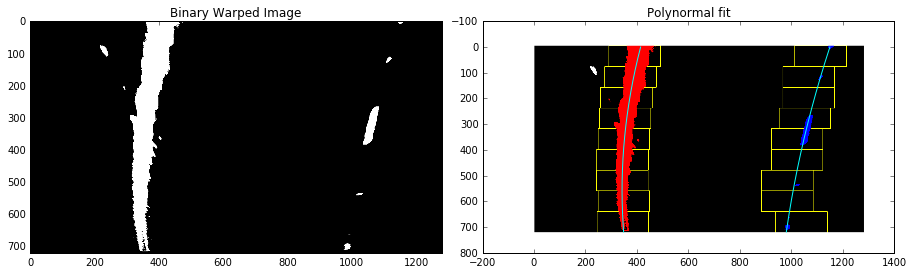

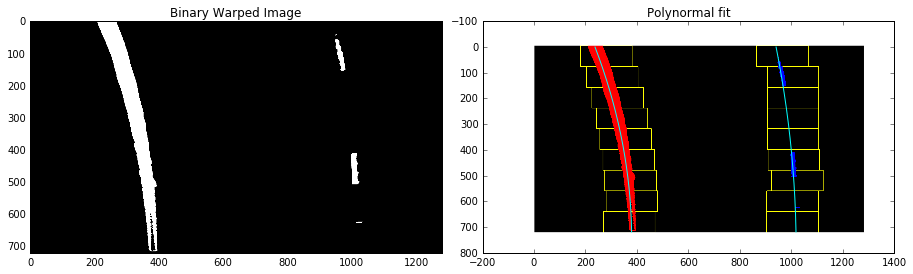

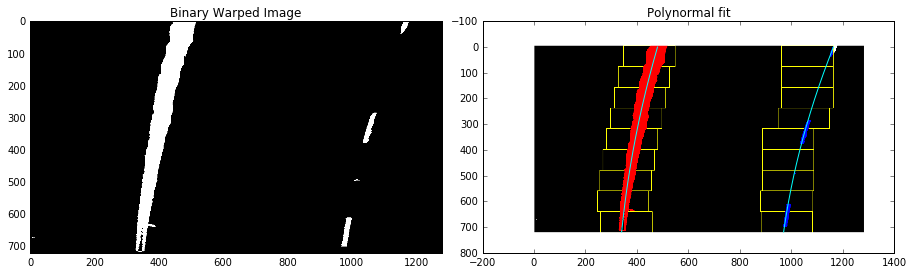

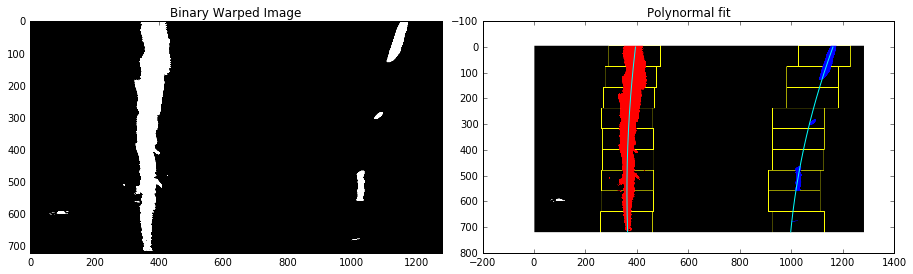

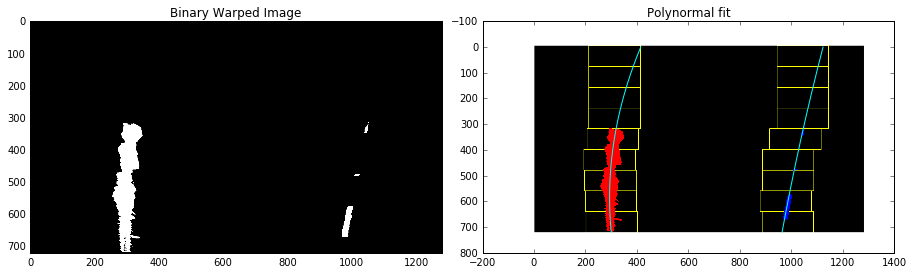

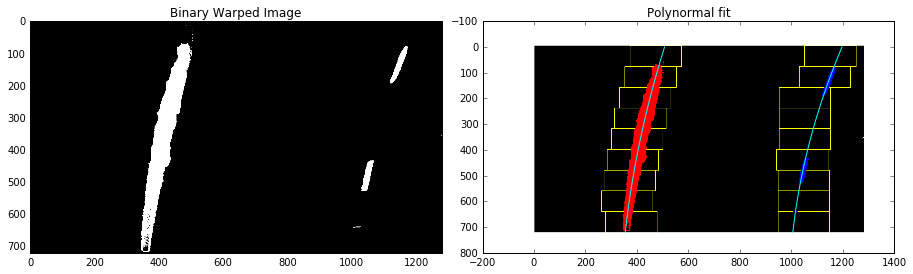

In [16]:
left_lanes=[]
right_lanes =[]
for i, im in enumerate(combined_binary_LB_images):
    left_fit, right_fit, out_img = poly_fit(im)
    left_lanes.append(left_fit)
    right_lanes.append(right_fit)

### Step 7:  Determine the curvature of the lane and vehicle position with respect to center


In [5]:
def calc_curvature(left_fit, right_fit, image):
    
    y_m_per_pix = 30/720 
    x_m_per_pix = 3.7/700 
    
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    y_eval = np.min(ploty)
    
    left_fit_x = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit_x = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
    left_fit_c = np.polyfit(ploty*y_m_per_pix, left_fit_x*x_m_per_pix, 2)
    right_fit_c = np.polyfit(ploty*y_m_per_pix, right_fit_x*x_m_per_pix, 2)

    
    left_curvature = ((1 + (2*left_fit_c[0]*y_eval*y_m_per_pix + 
                            left_fit_c[1])**2)**1.5) / np.absolute(2*left_fit_c[0])
    
    right_curvature = ((1 + (2*right_fit_c[0]*y_eval*y_m_per_pix +
                             right_fit_c[1])**2)**1.5) / np.absolute(2*right_fit_c[0])
    
    center = (((left_fit_c[0]*720**2+left_fit_c[1]*720+left_fit_c[2]) 
               +(right_fit_c[0]*720**2 + right_fit_c[1]*720+right_fit_c[2]) ) /2 - 640)*x_m_per_pix
    
    offset = ( image.shape[1]/2 - (left_fit_x[-1]+right_fit_x[-1])/2)*x_m_per_pix
    
    return left_curvature, right_curvature, center

In [57]:
calc_curvature(left_lanes[3], right_lanes[3], combined_binary_LB_images[3])

(1555.3236091931981,
 896.20719631016425,
 -2.2693738431454786,
 -0.21710294242810887)

After calculating the curvature it's time to draw the lanes back to the original images

In [6]:
def draw_Lines(img_org, img_thresh,left_fit, right_fit, dst,src):
    # Create an image to draw the lines on
    
    #if (left_fit is None) or (right_fit is None):
       
        #return img_org
    thresh_zero = np.zeros_like(img_thresh).astype(np.uint8)
    color_img_thresh = np.dstack((thresh_zero, thresh_zero, thresh_zero))
    
    ploty = np.linspace(0, img_thresh.shape[0]-1, img_thresh.shape[0])
    
    # Fit new polynomials to x,y in world space
    left_fit_x = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fit_x = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 
    
    #print(left_fit_x)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fit_x, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit_x, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    pers_p = cv2.getPerspectiveTransform(dst, src)

    # 
    cv2.fillPoly(color_img_thresh, np.int_([pts]), (255, 0, 255))
    
    # 
    new_img_thresh = cv2.warpPerspective(color_img_thresh, pers_p, (color_img_thresh.shape[1], color_img_thresh.shape[0])) 
   # new_img_thresh = cv2.cvtColor(new_img_thresh,cv2.COLOR_RGB2GRAY)
    
    #print (img_org.shape)
    #print (new_img_thresh.shape)
    result = cv2.addWeighted(img_org, 1, new_img_thresh, 0.3, 0)
    #result = cv2.addWeighted(img_org, 1, new_img_thresh, 0.5, 0)
    return(result, color_img_thresh)

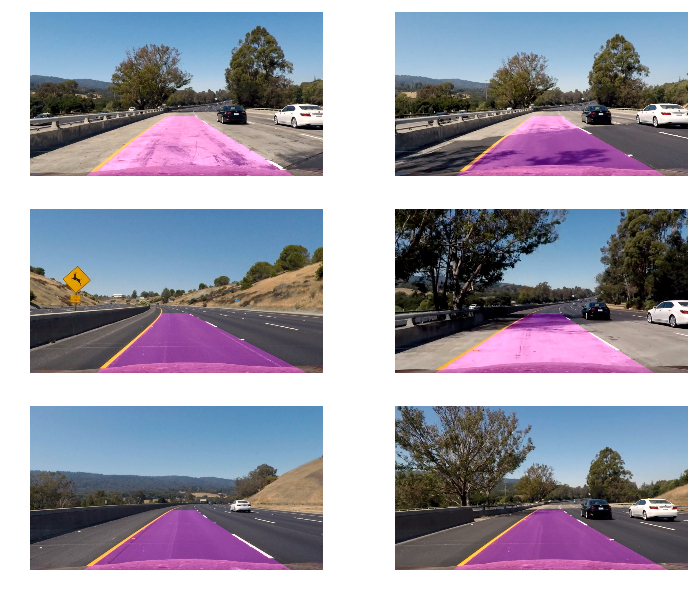

In [258]:
result_images = []
src = np.float32([[585, 460],[203, 720], 
                  [1127, 720],[695, 460]])
dst = np.float32([[320, 0], [320, 720], 
                  [960, 720],[960, 0]])
fig, ax = plt.subplots(3,2, figsize = (12,10))
for index,im in enumerate(images_cam):
    
    result_img,_ = draw_Lines(im, combined_binary_LB_images[index], left_lanes[index], right_lanes[index], dst, src)
    result_images.append(result_img)
    ax[index%3, int(index/3)].axis('off')
    ax[index%3, int(index/3)].imshow(result_img)

### Step 8:  Video Pipeline 

In [10]:
#Function to process the image
global counter
counter=0
ref_point_left =np.array([-0.0001,0,400])
ref_point_right=np.array([-0.0001,0,1000])   
left_fit =np.array([-0.0001,0,400])
right_fit=np.array([-0.0001,0,1000])   



def video_pipeline(image):
    
    ## sanity check
    def check_sanity(left_fit, right_fit, min_s, max_s):
        if len(left_fit) ==0 or len(right_fit) == 0:
            d1=0
            d2=0
        
        else:
        
            L_1 = 2*left_fit[0]*460+left_fit[1]
            R_1 = 2*right_fit[0]*460+right_fit[1]
            d1 =  np.abs(L_1-R_1)

            L_2 = 2*left_fit[0]*720+left_fit[1]
            R_2 = 2*right_fit[0]*720+right_fit[1]
            d2 =  np.abs(L_2-R_2)

        
            if d1>= min_s and d1<= max_s and d2>= min_s and d2<= max_s:
                return True
            else:
                return False
        return True
    

    ## polyfit update
    def poly_fit_update(left_fit, right_fit, warped):
        nonzero = warped.nonzero()
        nonzero_y = np.array(nonzero[0])
        nonzero_x = np.array(nonzero[1])
        margin = 100
        left_lane_idx = ((nonzero_x > (left_fit[0]*(nonzero_y**2) + left_fit[1]*nonzero_y + 
                                   left_fit[2] - margin)) & (nonzero_x < (left_fit[0]*(nonzero_y**2) + 
                                                                          left_fit[1]*nonzero_y + left_fit[2] +
                                                                          margin))) 
        right_lane_idx = ((nonzero_x > (right_fit[0]*(nonzero_y**2) + right_fit[1]*nonzero_y +
                                    right_fit[2] - margin)) & (nonzero_x < (right_fit[0]*(nonzero_y**2) +
                                                                            right_fit[1]*nonzero_y + right_fit[2] + 
                                                                            margin)))  

        left_x = nonzero_x[left_lane_idx]
        left_y = nonzero_y[left_lane_idx] 
        right_x = nonzero_x[right_lane_idx]
        right_y = nonzero_y[right_lane_idx]
    
        if len(left_x) == 0:
            left_fit_updated =[]
        else:
            left_fit_updated = np.polyfit(left_y, left_x, 2)
    
    
        if len(right_x) == 0:
            right_fit_updated =[]
        else:
            right_fit_updated = np.polyfit(right_y, right_x, 2)
        
        return  (left_fit_updated, right_fit_updated)
    ##
    
    global counter
    global ref_point_left 
    global ref_point_right
    global left_fit
    global right_fit
    

    image_size = (image.shape[1], image.shape[0])
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, corner_points, image_size, None, None)
    
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    src = np.float32([[585, 460],[203, 720], 
                      [1127, 720],[695, 460]])
    dst = np.float32([[320, 0], [320, 720], 
                      [960, 720],[960, 0]])
    
    Mp = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, Mp, image_size)
    img_thresh = combine_thresholds(warped)
    
    
    
    if counter==0:
        left_fit, right_fit,img_fit = poly_fit(img_thresh)
    else:
        left_fit, right_fit = poly_fit_update(left_fit, right_fit, img_thresh)

    check_sanity =check_sanity(left_fit, right_fit, 0, .55)

    
    if check_sanity  == True:        
        ref_point_left, ref_point_right = left_fit, right_fit        
        counter+=1
    else:       
        left_fit, right_fit = ref_point_left, ref_point_right
        
    #print (left_fit ,right_fit)    
    left_curv, right_curv, center_off = calc_curvature(left_fit, right_fit, img_thresh)

     
    result , viewb = draw_Lines(undist, img_thresh ,left_fit, right_fit, dst, src)
    

    #Write curvature and center in image
    TextL = "Left curv: " + str(int(left_curv)) + " m"
    TextR = "Right curv: " + str(int(right_curv))+ " m"
    #TextC = "Center offset: " + str(round( center_off,2)) + "m"

    fontScale=1
    thickness=2
    
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, TextL, (130,40), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(result, TextR, (130,70), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    #cv2.putText(result, TextC, (130,100), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    
    return result
        

### Step 9: Video Implementation

This pipeline will be used to process the video.

In [11]:
from moviepy.editor import VideoFileClip
vidout = 'output.mp4'
vidin = VideoFileClip('project_video.mp4')
processed_video = vidin.fl_image(video_pipeline)
%time processed_video.write_videofile(vidout, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [05:50<00:00,  3.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 5min 57s, sys: 40.6 s, total: 6min 38s
Wall time: 5min 51s


In [9]:
from IPython.display import HTML
HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('output.mp4'))

## Summary

This method has some limitation and I need to improve the code for two difficult videos since these videos have some issues like shadow and lane disconectivity. For the next step probabily I will work work on curve fitting algorithm as well as changing the condition in the scene like light changing and work with different thresholds. I will aslo may use smoothing technique on the binary image to reduce noise and remove ouliers. 